# Computer Vision

### Getting a dataset

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

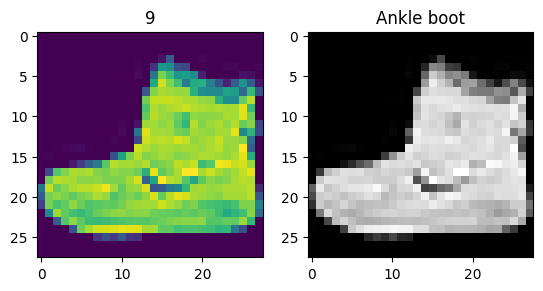

In [3]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze())
plt.title(label)

class_names = train_data.classes
plt.subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

### Prepare DataLoader

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### Model 0: Build a baseline model

In [5]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
model_0 = FashionMNISTModelV0(input_shape=784, 
    hidden_units=10,
    output_shape=len(class_names)
)

In [6]:
from helper_functions import accuracy_fn 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [7]:
torch.manual_seed(42)
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    
    ### Testing
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59408 | Test loss: 0.51082, Test acc: 81.99%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47918 | Test loss: 0.48672, Test acc: 82.96%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45645 | Test loss: 0.47981, Test acc: 83.33%



### Model 1: Building a better model with non-linearity

In [8]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [9]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------
Train loss: 1.29912 | Train accuracy: 55.32%
Test loss: 1.19533 | Test accuracy: 58.50%

Epoch: 1
---------
Train loss: 1.11160 | Train accuracy: 60.40%
Test loss: 1.09738 | Test accuracy: 60.70%

Epoch: 2
---------
Train loss: 1.07385 | Train accuracy: 61.23%
Test loss: 1.09993 | Test accuracy: 60.46%



### Model 2: Building a Convolutional Neural Network (CNN)

In [10]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------
Train loss: 0.59017 | Train accuracy: 78.63%
Test loss: 0.40196 | Test accuracy: 85.68%

Epoch: 1
---------
Train loss: 0.35938 | Train accuracy: 87.13%
Test loss: 0.34902 | Test accuracy: 87.11%

Epoch: 2
---------
Train loss: 0.32117 | Train accuracy: 88.28%
Test loss: 0.33987 | Test accuracy: 87.81%



### Making a confusion matrix

In [12]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    y_preds.append(y_pred)
y_pred_tensor = torch.cat(y_preds)

c:\Users\Tudor\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


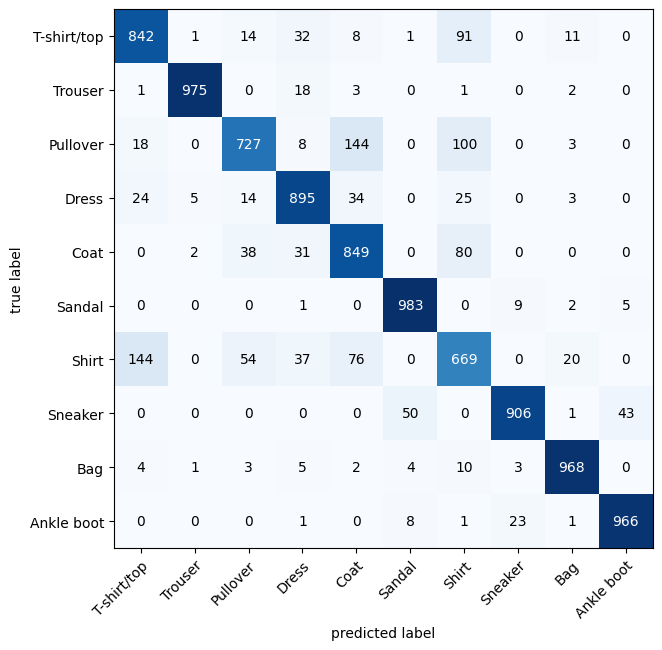

In [13]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names,
    figsize=(10, 7)
)

## Exercices

In [14]:
# 1. What are 3 areas in industry where computer vision is currently being used?
'''
"1. Self-driving cars, such as Tesla using computer vision to percieve what's happening on the road. See Tesla AI day for more - https://youtu.be/j0z4FweCy4M\n",
"2. Healthcare imaging, such as using computer vision to help interpret X-rays. Google also uses computer vision for detecting polyps in the intenstines - https://ai.googleblog.com/2021/08/improved-detection-of-elusive-polyps.html\n",
"3. Security, computer vision can be used to detect whether someone is invading your home or not - https://store.google.com/au/product/nest_cam_battery?hl=en-GB"
(from the course)
'''

'\n"1. Self-driving cars, such as Tesla using computer vision to percieve what\'s happening on the road. See Tesla AI day for more - https://youtu.be/j0z4FweCy4M\n",\n"2. Healthcare imaging, such as using computer vision to help interpret X-rays. Google also uses computer vision for detecting polyps in the intenstines - https://ai.googleblog.com/2021/08/improved-detection-of-elusive-polyps.html\n",\n"3. Security, computer vision can be used to detect whether someone is invading your home or not - https://store.google.com/au/product/nest_cam_battery?hl=en-GB"\n(from the course)\n'

In [15]:
# 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.
'''
Overfitting in machine learning occurs when a model becomes too complex and learns the noise and 
specific nuances of the training data, rather than the underlying general patterns.
'''

'\nOverfitting in machine learning occurs when a model becomes too complex and learns the noise and \nspecific nuances of the training data, rather than the underlying general patterns.\n'

In [16]:
# 5. Load the torchvision.datasets.MNIST() train and test datasets.

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

len(train_data)

60000

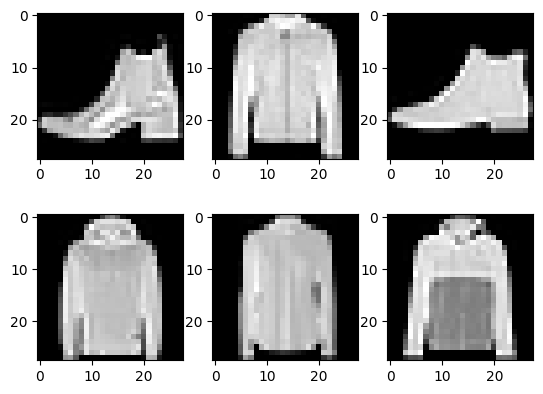

In [17]:
# 6. Visualize at least 5 different samples of the MNIST training dataset.
import random

for i in range(6):
   plt.subplot(2, 3, i+1)
   idx = random.randint(0, len(train_data))
   image, label = train_data[idx]
   plt.imshow(image.squeeze(), cmap="gray") 

plt.show()

In [18]:
# 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [22]:
# 8. Recreate model_2 used in this notebook (the same model from the CNN Explainer website, 
# also known as TinyVGG) capable of fitting on the MNIST dataset.

class TinyVGGModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
    
model_3 = TinyVGGModel(input_shape=1,
                       hidden_units=10,
                       output_shape=len(class_names))
model_3

TinyVGGModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [24]:
# 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    
    model_3.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        y_pred = model_3(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    ### Testing
    test_loss, test_acc = 0, 0 
    model_3.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_3(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        train_acc /= len(train_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Train acc: {train_acc:.5f} | Test acc: {test_acc:.2f}%\n")


Epoch: 0
-------
Looked at 0/60000 samples
Looked at 32000/60000 samples

Train loss: 1078.52515 | Test loss: 0.40689, Train acc: 79.27000 | Test acc: 85.36%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 32000/60000 samples

Train loss: 661.28156 | Test loss: 0.35519, Train acc: 87.31000 | Test acc: 86.81%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 32000/60000 samples

Train loss: 597.68713 | Test loss: 0.33366, Train acc: 88.55833 | Test acc: 88.18%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 32000/60000 samples

Train loss: 559.35553 | Test loss: 0.34462, Train acc: 89.29667 | Test acc: 86.99%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 32000/60000 samples

Train loss: 535.41522 | Test loss: 0.29723, Train acc: 89.69667 | Test acc: 89.35%



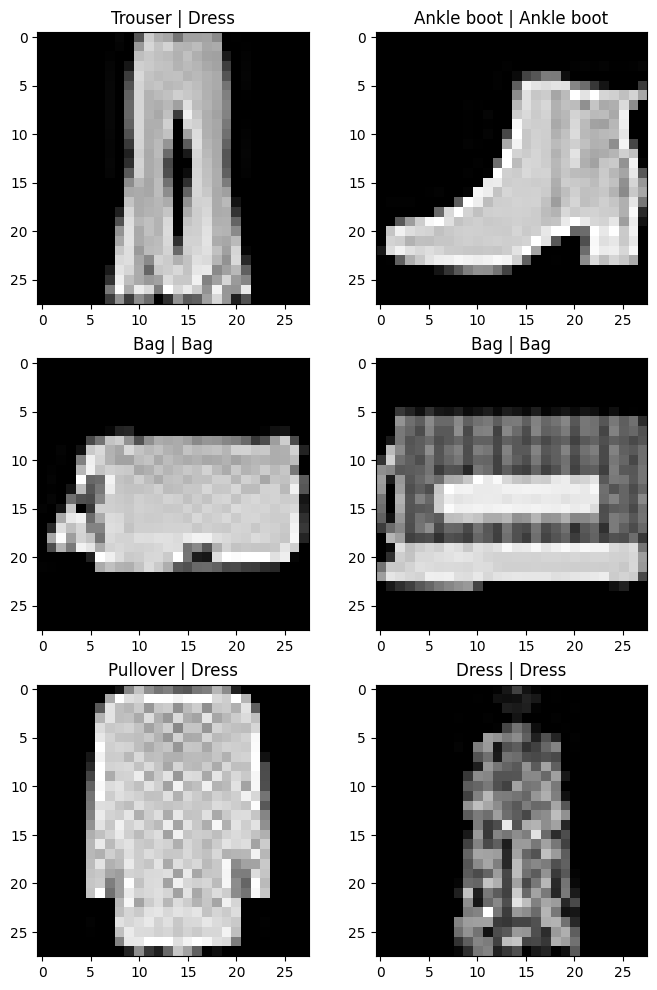

In [36]:
# 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

model_3.eval()
plt.figure(figsize=(8, 12))

for i in range(6):
   plt.subplot(3, 2, i+1)
   idx = random.randint(0, len(test_data))
   image, label = test_data[idx]
   plt.imshow(image.squeeze(), cmap="gray") 

   sample = image.unsqueeze(0)
   y_logit = model_3(sample)
   pred = torch.softmax(y_logit, dim=1).argmax(dim=1).item()
   plt.title(class_names[label] + " | " + class_names[pred])

plt.show()